In [12]:
import jax
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp


In [13]:
from funciones import get_farfield_radiant_intensity_percos_scalar

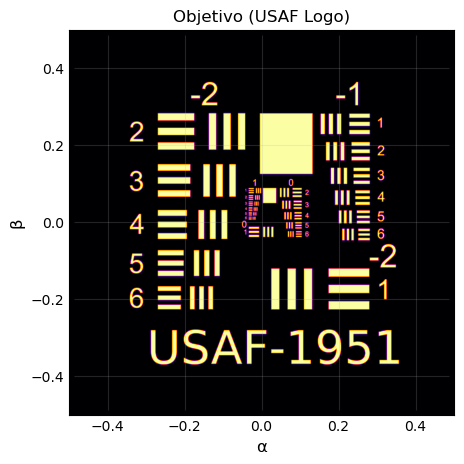

In [19]:
um = 1

USAF_logo = np.load('USAF_logo.npy')

from scipy.interpolate import RectBivariateSpline
α = np.linspace(-0.5, 0.5, 2000)
β = np.linspace(-0.5, 0.5, 2000)

fun_USAF= RectBivariateSpline(α, β, USAF_logo)


def target_fun(fxx, fyy):
    αα, ββ = fxx*λ, fyy*λ
    return np.abs(fun_USAF(αα[Ny//2,:],ββ[:,Nx//2]))


λ = 1.0*um
w_I = 200.0*um
def input_fun(xx,yy):
    rr = np.sqrt(xx**2 + yy**2)
    E = np.exp(-(rr**2)/(w_I**2))
    return E**2


fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(np.abs(fun_USAF(α,β)), origin = 'lower', cmap ='inferno',    extent = [α[0],α[-1],β[0],β[-1]])
ax.set_title(r"Objetivo (USAF Logo)")
ax.set_xlabel("α", size= 12)
ax.set_ylabel("β", size= 12)
plt.grid(alpha =0.2)
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)
plt.show()



In [15]:
def GS_phase_retrieval(input_fun,target_fun, extent_x, extent_y, Nx, Ny,num_iter = 40):
    """
    Calculates the phase profile using the Gerchberg-Saxton algorithm described in section 2.1.6
    
    Parameters
    ----------
    input_fun, target_fun: 2D functions with input and target functions
    extent_x, extent_y: float values with extent of the input function
    Nx, Ny: Number of points in which we divide each axis extent
    num_iter: number of iterations
    """
    dx, dy = extent_x/Nx,  extent_y/Ny
    x, y = dx*(jnp.arange(Nx)-Nx//2),  dy*(jnp.arange(Ny)-Ny//2)
    xx, yy = jnp.meshgrid(x, y)
    fx, fy = jnp.fft.fftshift(jnp.fft.fftfreq(Nx, d = dx)) , jnp.fft.fftshift(jnp.fft.fftfreq(Ny, d = dy))
    fxx, fyy = jnp.meshgrid(fx, fy)
    source_amplitude = jnp.abs(jnp.fft.ifftshift(jnp.sqrt(input_fun(xx, yy))))
    target_amplitude = jnp.abs(jnp.fft.ifftshift(jnp.sqrt(target_fun(fxx, fyy))/(dx*dy)))
    error_list = []
    U_p = jnp.fft.ifft2(jnp.fft.ifftshift(target_amplitude)) # Step 1  (from section 2.1.6)
    for iter in range(num_iter):
        U = source_amplitude * jnp.exp(1j * jnp.angle(U_p)) # Step 2
        Uf = jnp.fft.fft2(U) # Step 3
        Uf_p = target_amplitude * jnp.exp(1j * jnp.angle(Uf)) # Step 4
        U_p = jnp.fft.ifft2(Uf_p)  # Step 5
        
        diff = jnp.abs(Uf)  - target_amplitude
        squared_err = (jnp.mean(diff**2))
        error_list += [squared_err]
        print(squared_err)

    return jnp.fft.fftshift(jnp.angle(U_p)) , error_list

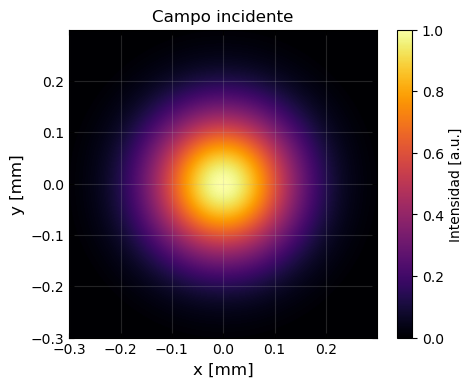

In [18]:
um = 1
mm = 1000
Nx = 4000
Ny = 4000

extent_x = extent_y = 600*um
extent_r = extent_x/2

dx = extent_x/Nx
dy = extent_y/Ny
x = dx*(np.arange(Nx)-Nx//2)
y = dy*(np.arange(Ny)-Ny//2)
xx, yy = np.meshgrid(x, y)
rr = np.sqrt(xx**2 +  yy**2)


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(input_fun(xx,yy), origin = 'lower', cmap ='inferno',    extent = [xx[0,0]/mm ,xx[0,-1]/mm ,yy[0,0]/mm ,yy[-1,0]/mm ])
cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label('Intensidad [a.u.]')
ax.set_title(r"Campo incidente")
ax.set_xlabel("x [mm]", size= 12)
ax.set_ylabel("y [mm]", size= 12)
plt.grid(alpha =0.2)
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)
plt.show()


In [7]:
retrieved_phase, error_list = GS_phase_retrieval(input_fun, target_fun, extent_x, extent_y, Nx, Ny,num_iter = 40)

2761484.3894310296
2755156.071969878
2755093.1506954194
2755085.756367645
2755083.028839196
2755082.473147311
2755082.0498245875
2755080.9165527225
2755072.5861199843
2755039.427302942
2754965.2949430104
2754858.509504505
2754754.5242232718
2754673.6987850163
2754615.992244543
2754575.178768296
2754545.405003452
2754522.8003059067
2754505.0111038033
2754490.591313166
2754478.656170198
2754468.637605516
2754460.1321549146
2754452.8248315644
2754446.4550025966
2754440.8156336728
2754435.77742401
2754431.2459857054
2754427.1452849363
2754423.408586032
2754419.9749010974
2754416.7915541898
2754413.8209094508
2754411.036910206
2754408.421667346
2754405.959685337
2754403.639355927
2754401.451655861
2754399.383012139
2754397.4248521635


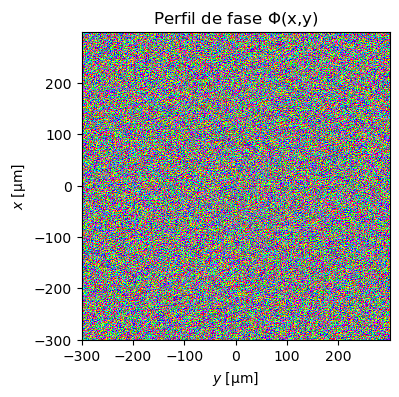

In [8]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)
ax.imshow(retrieved_phase %(np.pi*2), cmap = 'hsv', interpolation = 'none', extent = [x[0], x[-1], y[0], y[-1]])
ax.set_ylabel("$x$ [μm]")
ax.set_xlabel('$y$ [μm]')
ax.set_title(r"Perfil de fase $\Phi$(x,y)")

plt.show()



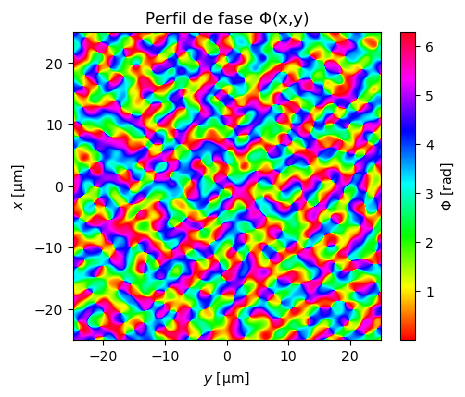

In [9]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)
im = ax.imshow((retrieved_phase) %(np.pi*2), cmap = 'hsv', origin = 'lower', interpolation = 'none', extent = [x[0], x[-1], y[0], y[-1]])
cb1 = fig.colorbar(im, orientation = 'vertical',fraction=0.045, label = '$\Phi$ [rad]')

ax.set_ylabel("$x$ [μm]")
ax.set_xlabel('$y$ [μm]')
ax.set_title(r"Perfil de fase $\Phi$(x,y)")
ax.set_xlim([-25,25])
ax.set_ylim([-25,25])
plt.show()


/home/rafael-fuente/anaconda3/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=complex64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


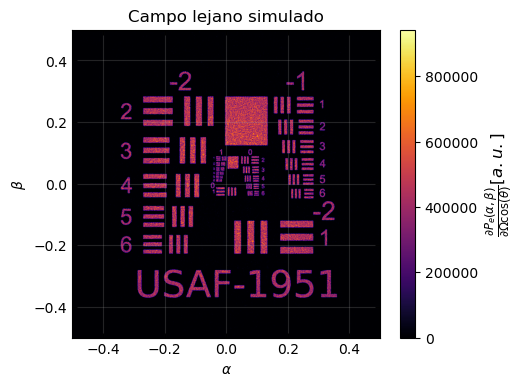

In [10]:
import sys 
sys.path.append('/home/rafael-fuente/') 
from field_propagation.jax.spherical_farfield import spherical_farfield_radiance, spherical_farfield_scalar_radiance,spherical_farfield_fft_radiance, spherical_farfield_fft_radiant_intensity



α, β, Irad = spherical_farfield_scalar_radiance(x, y, np.sqrt(input_fun(xx,yy))*np.exp(1j*(retrieved_phase)), λ, output_region = [-0.9999,0.9999,-0.9999,0.9999])



fig = plt.figure(figsize=(5, 4))

ax = fig.add_subplot(1,1,1)

im = ax.imshow(np.abs(Irad), origin = 'lower', cmap ='inferno',    extent = [-0.9999,0.9999,-0.9999,0.9999], vmax= np.abs(Irad).max()*0.5)

cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label(r"$\frac{\partial P_e(α,β)}{\partial \Omega \cos(\theta)} [a.u.]$", size= 12)



ax.set_title(r"Campo lejano simulado")
ax.set_xlabel('$α$')
ax.set_ylabel("$β$")
plt.grid(alpha =0.2)
ax.tick_params(axis='both', which="both", direction="in",right=True, top=True,)
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])


plt.show()
